In [1]:
%matplotlib inline
import json
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from statsmodels.nonparametric.kernel_regression import KernelReg

import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager

from scipy.stats import gaussian_kde
import re

In [2]:
# Set your directories accordingly
# Please adjust the following paths as needed
# data_dir = "/u/1/chenyang/benchmark_data/matrix_resource/data-all" 
# mat_dir = "/u/1/chenyang/benchmark_data/matrix_resource/solver-mat-0906"
data_dir = "/mnt/hdd1/chenyang/benchmark_data/matrix_resource/data-all" 
mat_dir = "/mnt/hdd1/chenyang/benchmark_data/matrix_resource/solver-mat-0906"

result_dir = "/u/1/chenyang/benchmark_data/exp-result/20250628_logging_expand"  # experiment metrics apart from mat
save_dir = "/u/1/chenyang/benchmark/analysis/output_test"
# solver_list = ["Pardiso", "Trilinos", "Trilinos-nullspace", "AMGCL", "Hypre"]
# solver_list = ["Pardiso", "AMGCL", "Hypre"]
solver_list = ["AMGCL", "Hypre"]

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# solver_list = [solver_list[2]]
# print(solver_list)

In [3]:
def get_mat_sz(fp):
    try:
        # the first 8 values are: dim, is_spd, is_sequence, nrow, ncol, nnz, outer_sz, inner_sz
        # nnz, number of non-zero element
        meta = np.fromfile(fp, dtype=np.int32, count=8, offset=0)
        n_rows = meta[3]
        return n_rows
    except:
        print("mat size exception")
        return None

def get_nnz(fp):
    try:
        meta = np.fromfile(fp, dtype=np.int32, count=8, offset=0)
        nnz = meta[5]
        return nnz
    except:
        print("nnz exception")
        return None

def get_density(nnz, mat_sz):
    if nnz is None or mat_sz is None:
        return None
    else:
        nnz =  np.float128(nnz)
        mat_sz =  np.float128(mat_sz)
        return (nnz + 1e-10) / (mat_sz * mat_sz + 1e-10)

def get_sparsity(nnz, mat_sz):
    if nnz is None or mat_sz is None:
        return None
    else:
        nnz =  np.float128(nnz)
        mat_sz =  np.float128(mat_sz)
        return (mat_sz * mat_sz - nnz) / (mat_sz * mat_sz)




In [4]:
def sequence_data(fname):
    if not os.path.exists(fname):
        print(fname)
        return None    
    seq = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            try:
                time = float(line.split(" ")[4])
                mem = float(line.split(" ")[5])
                seq.append([time, mem])
            except:
                seq.append([-1, -1])
                continue
    if len(seq) == 0:
        return None
    return seq

def sequence_data_trillinos(fname):
    if not os.path.exists(fname):
        return None    
    seq = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "[BOS]" in line:
                time = float(line.split(" ")[0].strip("[BOS]").strip("[EOS]"))
                mem = float(line.split(" ")[1])
                seq.append([time, mem])
            elif "Aborted (core dumped)" in line:
                seq.append([-1, -1])

    if len(seq) == 0:
        return None
    return seq

def sequence_data_hypre(fname):
    if not os.path.exists(fname):
        return None    
    seq = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "hypre error" in line:
                seq.append([-1, -1])
                continue
            if "hypre" not in line:
                try:
                    time = float(line.split(" ")[4])
                    mem = float(line.split(" ")[5])
                    seq.append([time, mem])
                except:
                    continue

    if len(seq) == 0:
        return None
    return seq

def check_bin_log(bin_path, log_file):
    start_i = 0
    start_j = 1
    end_i = 1000
    end_j = 1000

    
#     if os.path.exists(log_file):
#         with open(log_file,"r")as f:
#             last_line=f.readlines()[-1]
#             last_i=int(last_line.split(" ")[1])
#             last_j=int(last_line.split(" ")[2])
#         start_i=last_i+1
#         start_j=last_j+1
    
#     search_i = 1
#     while(search_i < 10000):
#         if os.path.exists(os.path.join(bin_path,"%d_%d_A.bin"%(search_i,1))):
#             break
#         search_i += 1

#     start_i = search_i

#     seq = []    
#     i = start_i
#     j = start_j
#     fp_a=os.path.join(bin_path,"%d_%d_A.bin"%(i,j))
#     fp_b=os.path.join(bin_path,"%d_%d_b.bin"%(i,j))
    i = start_i
    j = start_j
    search_first_file = False
    for out_i in range(start_i,end_i):
        for in_j in range(start_j,end_j):
            fp_a=os.path.join(bin_path,"%d_%d_A.bin"%(out_i,in_j))
            if os.path.exists(fp_a):
                i = out_i
                j = in_j
                search_first_file = True
                fp_b=os.path.join(bin_path,"%d_%d_b.bin"%(out_i,in_j))
                break
        if search_first_file:
#             print("found")
            break
    seq = []    
    
    while(os.path.exists(fp_a) and i < end_i):
        while(os.path.exists(fp_a) and j < end_j):
#     while(i < end_i):
#         while(j < end_j):
            if (os.path.exists(fp_a)):
                seq.append([i,j,fp_a, fp_b])
            j += 1
            fp_a=os.path.join(bin_path,"%d_%d_A.bin"%(i,j))
            fp_b=os.path.join(bin_path,"%d_%d_b.bin"%(i,j))
        j = 1
        i += 1
        fp_a=os.path.join(bin_path,"%d_%d_A.bin"%(i,j))
        fp_b=os.path.join(bin_path,"%d_%d_b.bin"%(i,j))
        
        
    return seq


In [5]:
def sequence_data_new(fname, solver):
    begin_line = []
    end_line = []
    with open(fname, 'r') as f:
        lines = f.readlines()  # read all lines into a list

    for i, line in enumerate(lines):
        if "[EXPBEGIN]" in line:
            begin_line.append(i)
        if "[EXPEND]" in line:
            end_line.append(i)

    len_begin = len(begin_line)
    len_end = len(end_line)
    if len_begin != len_end:
        print("#[EXPBEGIN] #[EXPEND] mismatches, unknown error formats.")

    begin_correct = []
    end_correct = []

    for begin_i, end_i in zip(begin_line, end_line):
        error_detected = False
        for j in range(begin_i, end_i):
            if "ERROR" in lines[j] or "error" in lines[j]:
#                 print(f"errors between {begin_i+1} line and {end_i+1} line")
                error_detected = True
                break
        if error_detected:
            continue 
        begin_correct.append(begin_i)
        end_correct.append(end_i)
    if error_detected:
        print("error in current exp: ", fname)


    seq = []
    for begin_i, end_i in zip(begin_correct, end_correct):
        element = {}
        element["solver_tol"] = float(lines[end_i-7].split(" ")[-1].strip())
        element["solver_maxiter"] = float(lines[end_i-6].split(" ")[-1].strip())
        element["final_res_norm"] = float(lines[end_i-5].split(" ")[-1].strip())
        print(element["final_res_norm"])
        element["num_iterations"] = float(lines[end_i-4].split(" ")[-1].strip())
        element["norm_b"] = float(lines[end_i-3].split(" ")[-1].strip())
        element["clock_time"] = float(lines[end_i-2].split(" ")[-1].strip().rstrip("s"))
        element["elapse_time"] = float(lines[end_i-1].split(" ")[-1].strip().rstrip("s"))
        
        if solver == "AMGCL":
            element["factorize"] = float(lines[end_i-11].split(" ")[-1].strip().rstrip("s"))
            element["solve"] = float(lines[end_i-10].split(" ")[-1].strip().rstrip("s"))
        seq.append(element)
    return seq



In [6]:
with open(os.path.join(data_dir, "filenames.json"), "r") as f:
    filenames = json.load(f)
    prenames = filenames["prenames"] # experiment name
    fpaths = filenames["fpaths"] # corresponding json file

    data_all = []
#     for solver in solver_list:
#         data_all[solver] = []

    for solver in solver_list:           
        for fpath, prename in zip(fpaths, prenames):
        
            fp = "%s/%s/%s.log" % (result_dir, solver, prename) #fp is final concat file path
            if not os.path.exists(fp):
                print(fp, "does not exist")
                continue
            seq_data = sequence_data_new(fp, solver)
            
            
#             if solver == "Trilinos" or solver == "Trilinos-nullspace":
#                 seq_data = sequence_data_trillinos(fp)
#             elif solver == "Hypre":
#                 seq_data = sequence_data_hypre(fp)
#             else:
#                 seq_data = sequence_data(fp)



            if len(seq_data) == 0:
                print("no log for this prename: ", prename, solver)
                break
#             print("seq_data lens: ", len(seq_data), "prename: ",prename )
     
    
            # evaluate whether #result = #bin, so the exps are correctly done
            bin_path = os.path.join(mat_dir, prename)
            bin_logged = check_bin_log(bin_path, fp)
#             print("bin_logged lens: ", len(bin_logged), "prename: ",prename )

            if len(seq_data) != len(bin_logged):
                print(solver, prename, "lens mismatching", "seq_data: ", len(seq_data), " bin_logged: ", len(bin_logged))
#             else:
#                 print(solver, prename, "lens matching", "seq_data: ", len(seq_data), " bin_logged: ", len(bin_logged))
                
            for element, bin_file in zip(seq_data , bin_logged):
                single_trial = {}
                single_trial["fpath"] = fpath
                single_trial["prename"] = prename
                single_trial["outer_i"] = bin_file[0]
                single_trial["inner_j"] = bin_file[1]
                single_trial["solver"] = solver
                single_trial["mat_sz"] = get_mat_sz(bin_file[2])
                single_trial["nnz"] = get_nnz(bin_file[2])
                single_trial["density"] = get_density(single_trial["nnz"], single_trial["mat_sz"])
                single_trial["sparsity"] = get_sparsity(single_trial["nnz"], single_trial["mat_sz"])

                single_trial["solver_tol"] = element["solver_tol"]
                single_trial["solver_maxiter"] = element["solver_maxiter"] 
                single_trial["final_res_norm"] = element["final_res_norm"] 
                single_trial["num_iterations"] = element["num_iterations"] 
                single_trial["norm_b"] = element["norm_b"]
                single_trial["clock_time"] = element["clock_time"]
                single_trial["elapse_time"] = element["elapse_time"]

                if solver == "AMGCL":
                    single_trial["factorize"] = element["factorize"]
                    single_trial["solve"] = element["solve"]
                    
                    
                data_all.append(single_trial)



    columns = ["fpath",     
               "prename", 
               "outer_i",
               "inner_j",
               "solver",
               "mat_sz",
               "nnz",
               "density",
               "sparsity",
               "solver_tol",
               "solver_maxiter",
               "final_res_norm",
               "num_iterations",
               "norm_b",
               "clock_time",
               "elapse_time"
              ]
    
    

    columns_more = ["factorize", "solve"]
    columns = columns + columns_more


    writer = pd.ExcelWriter(os.path.join(save_dir, 'profiling.xlsx'))
    df_all = pd.DataFrame(data_all, columns=columns)
    
#     #******log******
    
#     columns_log = [
#        "mat_sz",
#        "nnz",
#        "density",
#        "sparsity"]

#     mask = (df_all[columns_log] > 0).all(axis=1)
#     df_all_clean = df_all[mask].copy()
    
#     for col in columns_log:
#         df_all[col + "_log"] = np.log10(df_all_clean[col] + 1e-10)  # 防止 log(0)
        
#     print(df_all[[col + "_log" for col in columns_log]].head())    
#     #******log******

    print(df_all[[col for col in columns]].head())    
    df_all.to_excel(writer)
    writer.close()



1.4376e-15
2.6616e-18
9.3003e-18
2.768e-15
2.5297e-17
1.6022e-18
1.7788e-17
2.518e-13
3.1252e-16
3.8825e-18
5.5041e-17
3.3516e-15
2.8734e-11
3.1416e-16
9.3988e-19
1.1907e-16
1.628e-14
7.5187e-11
8.4977e-17
1.4406e-17
1.1647e-16
3.082e-14
2.4973e-11
1.6696e-16
2.6161e-11
4.1387e-18
1.7004e-14
2.7379e-12
3.0029e-16
7.9264e-18
6.5722e-17
1.8219e-14
1.0619e-11
1.7016e-17
4.8239e-18
4.0258e-17
1.3307e-14
2.6216e-11
1.5397e-16
1.2925e-17
8.3992e-17
2.439e-14
8.8058e-12
1.6953e-16
2.8856e-19
3.7233e-17
4.458e-14
2.6514e-13
9.7054e-17
7.5354e-18
7.826e-17
1.4004e-14
3.1766e-11
3.5313e-16
1.114e-18
5.3094e-17
1.3098e-14
7.1722e-11
9.9394e-17
7.9722e-18
3.598e-18
1.0885e-14
3.9488e-11
1.8383e-16
1.0286e-17
4.674e-17
1.1507e-14
5.7219e-11
1.8715e-16
1.0293e-18
1.0605e-17
1.1589e-14
7.0832e-11
6.4135e-17
6.6214e-18
8.7363e-18
3.6183e-14
1.9284e-11
2.7364e-17
3.0879e-18
1.5783e-16
7.5916e-14
2.8252e-12
1.778e-16
1.8439e-17
6.6269e-17
5.5065e-14
8.3835e-14
1.3077e-17
7.5301e-19
1.6345e-17
1.4464e-13

9.9104e-11
6.7712e-11
3.5271e-11
6.8548e-11
2.1411e-11
1.7855e-12
5.885e-11
4.602e-11
5.6593e-12
8.5163e-11
3.8677e-11
6.4852e-12
1.0257e-11
1.8273e-11
2.067e-12
7.3133e-11
2.8788e-11
5.3322e-11
6.9538e-12
3.747e-11
2.1862e-11
9.8069e-12
8.1863e-12
9.6061e-11
2.9317e-12
5.7248e-11
6.8414e-11
5.9944e-11
5.7143e-11
2.0602e-11
4.2686e-11
3.852e-11
1.2854e-12
2.8115e-12
9.4766e-11
1.4878e-12
6.1481e-12
7.2382e-11
7.7448e-12
5.9319e-11
1.6145e-11
9.3497e-12
1.2305e-11
5.4558e-11
3.7497e-11
9.912e-11
4.3436e-11
1.9667e-11
2.0153e-11
2.2441e-11
2.5461e-11
3.0474e-12
3.6125e-12
8.8615e-12
1.5502e-11
9.3319e-11
6.3619e-11
4.7752e-11
2.0827e-11
6.2886e-11
6.0468e-11
8.1801e-12
3.205e-11
3.2578e-11
6.5611e-11
8.4217e-11
3.6249e-11
5.5664e-11
4.0759e-11
5.4005e-12
6.9323e-12
3.5021e-11
9.4744e-11
8.0708e-11
6.3344e-11
6.0866e-11
3.0077e-11
4.8666e-11
8.2798e-11
5.2365e-11
1.262e-11
2.2913e-11
4.6505e-11
2.9883e-11
1.2687e-11
5.2955e-11
4.082e-12
5.4192e-11
5.5918e-11
5.7931e-11
3.2982e-11
2.1611e-

1.5228e-14
2.7416e-14
1.2411e-14
7.7417e-11
1.7876e-11
1.8614e-11
9.4074e-14
1.0393e-13
1.5737e-12
3.0666e-12
9.6927e-13
1.6065e-11
7.3105e-11
4.0081e-12
2.9215e-13
1.4895e-12
2.7658e-12
1.4744e-11
1.6322e-11
2.5754e-12
6.698e-12
3.0945e-12
1.6428e-12
3.1936e-12
2.4809e-12
2.995e-12
1.6031e-11
3.5107e-13
1.4597e-12
1.5677e-12
3.1596e-12
8.7848e-13
2.9732e-12
1.4849e-11
5.3825e-13
3.0478e-12
1.3937e-12
3.1614e-12
8.5111e-13
2.9375e-12
2.5242e-11
7.8845e-13
3.4574e-12
9.5937e-13
3.1616e-12
8.5926e-13
2.846e-12
3.187e-11
4.5995e-13
3.5772e-12
1.4389e-13
2.7231e-12
3.5162e-11
6.6048e-12
3.6968e-12
7.0754e-13
2.5826e-12
3.1058e-11
2.6719e-12
3.8107e-12
1.2747e-12
2.4322e-12
1.5675e-11
2.435e-12
3.9183e-12
1.5256e-12
2.2243e-12
2.2771e-12
3.1581e-11
1.4849e-12
1.6478e-12
2.2258e-12
2.1198e-12
2.1341e-11
1.5535e-12
1.7065e-12
2.2272e-12
1.963e-12
2.2698e-11
1.6229e-12
1.7383e-12
2.2286e-12
1.8077e-12
3.2946e-11
1.6939e-12
1.7549e-12
2.2297e-12
1.6551e-12
6.9327e-11
1.7679e-12
1.7617e-12
2.230

1.5228e-14
2.7416e-14
1.2411e-14
7.7417e-11
1.7876e-11
1.8614e-11
9.3699e-14
1.2687e-13
1.6416e-12
3.1655e-12
9.8176e-13
2.1687e-11
6.2443e-11
3.1593e-13
2.2666e-11
4.3528e-11
5.7984e-11
2.471e-11
2.853e-12
3.8384e-12
1.5539e-12
1.1761e-11
3.8189e-11
1.912e-11
1.9865e-12
1.4846e-11
3.891e-11
2.1601e-11
1.9739e-12
1.4878e-11
3.8912e-11
2.3008e-11
1.9764e-12
1.5065e-11
3.8956e-11
2.3617e-11
1.9797e-12
1.5202e-11
3.9004e-11
2.3903e-11
1.9812e-12
1.527e-11
3.9027e-11
2.4045e-11
1.982e-12
1.5303e-11
3.9038e-11
2.4117e-11
1.9824e-12
1.5321e-11
3.9044e-11
2.4154e-11
1.9826e-12
1.533e-11
3.9047e-11
2.4173e-11
1.9827e-12
1.5334e-11
3.9049e-11
2.4182e-11
1.9827e-12
1.5337e-11
3.905e-11
2.4188e-11
1.9827e-12
1.5338e-11
3.905e-11
2.419e-11
1.9828e-12
1.5339e-11
3.905e-11
2.4192e-11
1.9828e-12
1.5339e-11
3.905e-11
2.4192e-11
1.9828e-12
1.5339e-11
3.905e-11
2.4193e-11
1.9828e-12
1.5339e-11
3.905e-11
2.4193e-11
1.9828e-12
1.5339e-11
3.905e-11
2.4193e-11
1.9828e-12
1.5339e-11
3.905e-11
2.4193e-11
1.98

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


9.8019e-12
1.79e-11
9.8019e-12
1.5605e-11
9.8019e-12
9.8019e-12
1.985e-12
4.8437e-12
3.858e-12
6.9683e-12
5.4593e-12
3.0968e-12
5.8252e-12
6.2663e-11
2.9618e-12
2.6155e-12
3.1532e-12
1.9166e-12
1.4725e-12
1.6727e-11
3.9892e-12
1.4416e-11
5.49e-12
3.444e-12
3.3693e-12
1.502e-12
9.4573e-11
2.0412e-11
1.4524e-11
4.559e-12
5.6058e-11
2.9866e-12
4.0135e-12
4.4525e-12
1.157e-12
5.3634e-11
2.7539e-11
3.6556e-11
3.8386e-11
3.1031e-12
1.1512e-11
2.1174e-11
3.2262e-12
8.0348e-13
2.8448e-12
2.037e-11
1.5601e-11
1.307e-11
7.3453e-12
3.1164e-11
1.2245e-12
2.2375e-12
5.5313e-11
8.5438e-11
7.2025e-11
8.8923e-11
9.9275e-11
1.8255e-12
7.5643e-11
5.8889e-11
1.8933e-11
5.7578e-11
1.3017e-11
2.9594e-12
2.4154e-11
2.8706e-12
2.5312e-12
2.9505e-11
3.3996e-11
9.4423e-11
9.9254e-11
4.9776e-11
7.5293e-12
7.4296e-12
1.2467e-11
4.385e-12
3.153e-12
4.1274e-12
3.1099e-11
3.259e-11
2.8396e-11
2.4035e-11
3.408e-11
2.9419e-11
2.3548e-11
3.7952e-11
8.8754e-12
6.4356e-12
1.7942e-12
1.0204e-12
2.3848e-11
8.2972e-12
3.60

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1.1289e-16
nan
nan
nan
1.9558e-16
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

1.412e-21
9.8032e-12
1.1559e-21
6.6885e-11
2.1671e-21
9.9901e-17
1.0428e-21
2.3409e-21
7.9958e-14
4.0018e-13
3.4651e-15
2.4732e-11
2.0575e-12
2.0355e-13
3.1491e-13
3.8044e-12
2.9069e-11
8.3301e-11
2.0743e-13
1.3832e-12
4.8026e-11
6.1875e-14
5.4329e-12
1.1301e-11
2.2822e-11
4.5009e-11
9.566e-12
2.8173e-11
8.7045e-11
1.8393e-12
4.532e-13
4.9667e-12
4.9106e-12
3.0619e-12
5.0619e-11
6.4589e-12
3.1778e-12
2.4826e-11
7.3079e-12
2.3854e-12
2.301e-11
8.1537e-12
6.4832e-12
3.1033e-11
2.0395e-12
5.7028e-12
4.6274e-11
2.4887e-12
3.1696e-12
3.4759e-11
3.4374e-12
7.7318e-11
8.482e-11
3.4035e-11
3.251e-12
3.7822e-11
3.7945e-12
1.415e-11
8.3564e-12
7.8932e-11
9.2588e-12
8.8121e-11
8.5967e-12
5.8345e-11
6.3611e-12
3.8271e-11
4.1303e-12
1.3881e-11
3.5347e-12
2.8007e-11
4.1854e-12
7.0818e-11
4.2407e-12
5.3494e-11
3.9795e-12
1.7835e-11
2.6136e-13
1.2319e-11
3.8922e-12
1.9533e-11
3.8625e-12
2.2521e-12
3.6719e-12
9.6244e-12
3.3906e-12
1.5334e-11
2.8443e-12
1.3486e-11
1.0652e-12
1.3175e-11
1.0718e-13
1.3002

1.8912e-12
1.0975e-12
2.5746e-12
1.2617e-11
1.3907e-11
3.3311e-11
1.4642e-12
1.4649e-12
1.7377e-12
2.4142e-12
2.4513e-12
1.2583e-11
6.9879e-12
8.5139e-12
3.6926e-11
3.0725e-12
4.4306e-11
2.8433e-12
1.2567e-11
2.3203e-11
3.6899e-12
8.5242e-11
1.4402e-12
2.0689e-12
9.6964e-13
2.4136e-12
1.2521e-11
7.2665e-11
3.2933e-12
2.3262e-12
3.1326e-12
2.7579e-12
2.6421e-12
2.5488e-12
1.2507e-11
7.7548e-11
3.6447e-12
2.7692e-12
3.5236e-12
2.8302e-12
2.673e-12
2.5673e-12
1.2488e-11
8.4524e-11
4.0501e-12
3.0331e-12
3.8276e-12
2.9061e-12
2.703e-12
2.5826e-12
1.2472e-11
2.447e-12
4.5202e-12
2.5447e-12
3.7974e-12
2.9756e-12
2.731e-12
2.5941e-12
1.2461e-11
3.0147e-12
5.0658e-12
6.8968e-11
3.5015e-12
3.0044e-12
2.7548e-12
2.6006e-12
1.2461e-11
3.2965e-12
5.6782e-12
9.1968e-11
3.3942e-12
2.8992e-12
2.7684e-12
2.6001e-12
1.2445e-11
3.5716e-12
6.3758e-12
9.9872e-11
2.0727e-12
2.5832e-12
2.7631e-12
2.5985e-12
1.2452e-11
4.1234e-12
7.1147e-12
9.0012e-11
2.4592e-12
2.1308e-12
2.6839e-12
2.5945e-12
1.2455e-11
5.1

9.2505e-11
6.7828e-11
9.2718e-11
7.9196e-11
9.5611e-11
9.4333e-11
9.2701e-11
7.7317e-11
7.3802e-11
7.0346e-06
0.13335
0.8828
1.0048
0.71521
0.99815
1.0001
1.0001
0.99953
1.0001
1.0001
0.05141
1.9328
0.99914
1.0177
1.0008
0.18707
1.0002
1.0002
1.0003
1.0002
1.0051
1.0012
1.0023
0.39758
1.0006
1.0008
1.0007
7.9206
1.0472
0.74535
2.9175
0.096232
1.0238
9.4961e-11
1.0421
1.0484
1.0423
1.0326
0.060839
1.5838
5.9381e-11
1.0939
1.0464
0.85969
8.2468e-11
0.86003
9.7767e-11
1.0624
1.0363
1.0351
1.9295
0.9584
0.18329
0.065431
9.4313e-11
6.3316e-06
6.121e-05
0.98348
1.0321
1.0004
7.9955e-11
1.6483e-07
5.0343e-08
1.36e-07
6.5881e-08
9.211e-05
4.6876e-05
1.6377e-05
2.1224e-05
0.0001968
9.2411e-05
3.3012e-05
8.6395e-06
1.5907e-06
9.6536e-11
9.5928e-11
3.8433e-10
7.7215e-11
5.7951e-10
3.8544e-09
9.492e-11
7.9779e-11
9.7687e-11
8.5373e-11
9.5573e-11
1.0608e-10
9.6938e-11
9.8254e-11
3.032e-06
3.8806e-07
4.3955e-09
9.5085e-11
9.8875e-11
9.9342e-11
7.9891e-10
0.188
0.025588
1.0021
0.0013666
0.0013381
0.6

1.6351e-12
1.6354e-12
1.6374e-12
1.6373e-12
1.6371e-12
1.6369e-12
1.6347e-12
1.6337e-12
1.6331e-12
1.6329e-12
1.6336e-12
1.6262e-12
1.6253e-12
1.6249e-12
1.6159e-12
1.6116e-12
1.6111e-12
1.614e-12
1.6124e-12
1.6123e-12
1.6212e-12
1.6204e-12
1.6243e-12
1.6241e-12
1.6341e-12
1.6329e-12
1.6324e-12
1.6763e-12
1.6349e-12
1.5859e-12
1.5836e-12
1.5834e-12
1.5846e-12
1.5842e-12
1.5841e-12
1.6484e-12
1.6491e-12
1.6359e-12
1.6296e-12
1.6288e-12
1.632e-12
1.6192e-12
1.597e-12
1.5869e-12
1.5861e-12
1.5756e-12
1.5391e-12
1.5132e-12
1.5025e-12
1.4992e-12
1.4767e-12
1.4722e-12
1.4711e-12
1.4807e-12
1.4091e-12
1.4034e-12
1.401e-12
1.4e-12
1.4436e-12
1.3491e-12
1.3509e-12
1.352e-12
1.3806e-12
1.3697e-12
1.358e-12
1.3599e-12
1.6018e-12
1.6044e-12
1.5657e-12
1.5994e-12
1.5258e-12
1.4912e-12
1.4843e-12
1.4681e-12
1.4661e-12
1.4661e-12
1.4499e-12
1.4782e-12
1.4738e-12
1.4697e-12
1.4597e-12
1.3996e-12
1.3576e-12
1.3529e-12
1.5289e-12
1.4362e-12
1.4297e-12
1.3454e-12
1.3401e-12
1.3291e-12
1.3198e-12
1.3158e-

/u/1/chenyang/benchmark_data/exp-result/20250628_logging_expand/AMGCL/kick.log does not exist
9.7886e-11
9.9525e-11
9.4258e-11
9.8479e-11
9.5193e-11
8.8102e-11
8.5817e-11
8.5087e-11
8.1756e-11
8.8874e-11
8.9805e-11
8.4786e-11
7.3176e-11
9.8267e-11
6.8819e-11
6.2792e-11
7.699e-11
8.0232e-11
7.5515e-11
5.8246e-11
6.6784e-11
4.0403e-11
6.1661e-11
5.7513e-11
5.8589e-11
6.7673e-11
6.7634e-11
7.7291e-11
9.5525e-11
8.4614e-11
5.8037e-11
5.8603e-11
7.1991e-11
5.065e-06
0.0009578
9.6874e-11
7.6552e-11
7.7099e-11
7.114e-11
8.2712e-11
8.9885e-11
5.1089e-11
9.3374e-11
8.2278e-11
7.4196e-11
6.2745e-11
7.1533e-11
6.3771e-11
5.2718e-11
9.8442e-11
9.7836e-11
9.7551e-11
8.2836e-11
7.5932e-11
8.6239e-11
8.6436e-11
8.353e-11
8.9159e-11
8.3802e-11
9.0485e-11
8.3493e-11
9.0815e-11
7.2895e-11
9.7352e-11
0.0021511
0.0010265
8.0036e-11
8.8083e-11
0.57996
7.9998e-11
5.8867e-11
6.8227e-11
7.8911e-11
5.4389e-11
9.0411e-11
9.1239e-11
7.5869e-11
4.7403e-11
6.2824e-11
8.8314e-11
5.4967e-11
5.4893e-11
8.1969e-11
9.5

6.1425e-11
8.5072e-11
7.1818e-11
7.278e-11
7.5612e-11
7.6904e-11
9.4547e-11
9.2384e-11
8.2762e-11
7.7244e-11
9.1777e-11
7.5884e-11
8.3546e-11
5.573e-11
8.6885e-11
5.1686e-11
5.7141e-11
7.279e-11
6.5689e-11
8.2689e-11
7.8497e-11
7.4437e-11
6.5473e-11
9.321e-11
9.5761e-11
7.1999e-11
7.1168e-11
8.1862e-11
9.5528e-11
5.8399e-11
6.6543e-11
7.9514e-11
8.6297e-11
6.4989e-11
8.9027e-11
9.2475e-11
6.6626e-11
8.537e-11
9.477e-11
7.3448e-11
8.738e-11
8.3516e-11
7.0845e-11
6.502e-11
5.8872e-11
6.7563e-11
9.3763e-11
6.2096e-11
8.91e-11
8.3536e-11
7.2507e-11
9.0695e-11
7.9917e-11
5.449e-11
6.1214e-11
6.9148e-11
7.7274e-11
6.0477e-11
7.1914e-11
8.014e-11
6.1483e-11
7.6922e-11
7.9821e-11
8.5319e-11
7.6278e-11
8.571e-11
6.0773e-11
9.74e-11
9.3334e-11
8.8797e-11
9.2918e-11
6.8255e-11
8.7688e-11
7.8409e-11
9.6268e-11
8.0046e-11
8.4166e-11
6.9192e-11
7.47e-11
9.655e-11
9.2392e-11
7.2661e-11
9.4345e-11
7.4387e-11
7.2127e-11
6.3161e-11
6.1298e-11
9.3896e-11
9.5515e-11
6.4374e-11
9.0725e-11
7.7612e-11
7.659e

9.6302e-11
8.3712e-11
8.9461e-11
9.3537e-11
9.9707e-11
7.1613e-11
8.5163e-11
9.5954e-11
8.1184e-11
6.3835e-11
8.4691e-11
8.1404e-11
8.6686e-11
9.1209e-11
8.8488e-11
7.4911e-11
8.911e-11
7.1343e-11
6.2611e-11
8.9714e-11
7.4357e-11
9.7627e-11
9.7948e-11
8.8228e-11
9.3575e-11
9.6518e-11
8.9057e-11
8.2812e-11
7.2847e-11
9.2271e-11
9.0728e-11
6.3571e-11
6.2647e-11
9.1605e-11
9.2079e-11
9.5773e-11
9.0759e-11
7.5284e-11
7.244e-11
9.8271e-11
8.7006e-11
8.3303e-11
9.4373e-11
9.7768e-11
6.5781e-11
8.4326e-11
6.9044e-11
8.9083e-11
7.065e-11
9.4761e-11
7.2026e-11
7.8105e-11
7.3174e-11
8.0569e-11
7.3737e-11
8.3389e-11
7.4242e-11
8.6626e-11
7.4686e-11
8.8224e-11
7.4906e-11
8.3206e-11
6.6865e-11
8.3115e-11
9.3944e-11
9.2812e-11
8.0471e-11
9.6064e-11
9.8101e-11
9.0735e-11
8.1379e-11
8.2536e-11
9.2989e-11
8.0032e-11
7.1574e-11
7.0825e-11
9.6957e-11
9.557e-11
9.4334e-11
8.0934e-11
9.6166e-11
6.4235e-11
9.9453e-11
6.6407e-11
6.9907e-11
6.1707e-11
9.2869e-11
7.1023e-11
8.5022e-11
9.073e-11
8.736e-11
8.879

nan
1.8597e-20
nan
3.4596e-20
nan
2.1315e-20
nan
1.0042e-19
nan
1.1975e-19
nan
1.0291e-19
nan
1.3468e-19
nan
1.3662e-19
nan
1.2456e-19
nan
4.9823e-19
nan
2.8188e-19
nan
2.7644e-19
nan
3.1735e-19
nan
5.1429e-19
nan
5.1429e-19
nan
5.143e-19
nan
5.1429e-19
nan
5.5609e-19
nan
5.1429e-19
nan
1.0676e-18
nan
1.0682e-18
nan
1.0649e-18
nan
1.0654e-18
nan
1.0642e-18
nan
1.0648e-18
nan
1.0656e-18
nan
1.0646e-18
nan
1.0637e-18
nan
1.0622e-18
nan
1.0634e-18
nan
1.0624e-18
nan
1.0633e-18
nan
1.2509e-18
nan
1.0899e-18
nan
1.3048e-18
nan
1.3088e-18
nan
1.2408e-18
nan
1.243e-18
nan
1.3181e-18
nan
5.4526e-18
nan
5.2532e-18
nan
5.3958e-18
nan
5.455e-18
nan
5.6078e-18
nan
5.3731e-18
nan
5.3728e-18
nan
5.4842e-18
nan
5.7921e-18
nan
5.4354e-18
nan
5.3096e-18
nan
5.3091e-18
nan
5.3085e-18
nan
5.363e-18
nan
5.4064e-18
nan
5.8272e-18
nan
7.3555e-18
nan
7.3462e-18
nan
7.3359e-18
nan
7.3526e-18
nan
7.357e-18
nan
7.3455e-18
nan
7.4091e-18
nan
7.3573e-18
nan
7.3554e-18
nan
7.6371e-18
nan
7.4227e-18
nan
7.4216e-18


/u/1/chenyang/benchmark_data/exp-result/20250628_logging_expand/AMGCL/5-cubes-hex-fast.log does not exist
/u/1/chenyang/benchmark_data/exp-result/20250628_logging_expand/AMGCL/5-cubes-hex.log does not exist
1.4217e-11
2.0292e-11
2.6564e-11
1.405e-11
1.8955e-11
2.65e-11
1.3978e-11
1.8373e-11
2.57e-11
1.3961e-11
1.906e-11
2.5422e-11
1.3958e-11
2.0451e-11
2.5918e-11
1.3955e-11
2.1586e-11
2.4421e-11
1.3969e-11
2.209e-11
2.2106e-11
1.4015e-11
2.2041e-11
2.1117e-11
1.4074e-11
2.1645e-11
2.0975e-11
1.4152e-11
2.1191e-11
2.124e-11
1.4355e-11
2.0868e-11
2.1855e-11
1.4681e-11
2.0627e-11
2.2443e-11
1.4871e-11
2.0327e-11
2.2878e-11
1.4764e-11
2.0033e-11
2.3379e-11
1.4517e-11
5.8771e-12
0.75844
9.353e-11
0.015047
0.0043199
0.0003829
0.012507
0.00098829
9.1452e-11
0.0073904
0.48457
7.3714e-11
6.1062e-11
9.8437e-11
5.3336e-10
5.457e-11
7.3635e-11
8.3811e-11
9.6086e-11
7.0685e-11
8.869e-11
4.7665e-11
3.9703e-11
6.5269e-11
5.3385e-11
2.3642e-11
8.5405e-11
3.6243e-11
4.2367e-11
6.0158e-11
4.7055e-11
0.0

1.7434e-16
1.1511e-16
4.9547e-30
1.3276e-16
1.862e-24
0.0
0.0
1.7428e-16
1.5179e-25
1.7428e-16
1.2818e-16
9.7387e-25
9.8601e-18
1.7428e-16
1.8907e-16
3.9627e-29
1.7621e-16
6.1917e-31
1.1784e-16
6.1917e-31
2.9055e-16
1.5479e-31
1.492e-16
6.1917e-31
0.0
1.7428e-16
1.1806e-16
1.8575e-30
1.064e-19
1.7428e-16
1.1806e-16
1.2383e-30
1.064e-19
6.1917e-31
2.9055e-16
6.1917e-31
0.0
6.1917e-31
0.0
6.1917e-31
1.1806e-16
1.2383e-30
1.4679e-16
0.0
1.4745e-30
0.0
0.0
0.0
0.0
1.2383e-30
1.1807e-16
6.1917e-31
1.064e-19
6.1917e-31
1.1806e-16
6.1917e-31
1.064e-19
6.1917e-31
1.064e-19
6.1917e-31
0.0
6.1917e-31
1.064e-19
6.1917e-31
1.1806e-16
6.1917e-31
1.064e-19
6.1917e-31
1.1806e-16
6.1917e-31
0.0
6.1917e-31
0.0
6.1917e-31
0.0
6.1917e-31
0.0
6.1917e-31
1.1806e-16
6.1917e-31
0.0
6.1917e-31
0.0
1.7428e-16
0.0
2.1274e-20
1.6111e-16
2.0126e-16
1.3049e-20
9.7053e-18
1.7314e-16
1.5179e-16
0.0
0.0
1.0406e-19
1.7428e-16
1.963e-16
4.0578e-26
1.161e-16
5.0722e-27
1.8348e-16
0.0
1.5789e-16
1.2383e-30
2.0957e-16
1.7

3.1098e-11
3.8561e-12
8.6744e-14
1.0237e-13
7.46e-13
2.2267e-13
2.0739e-11
4.997e-11
2.0832e-11
7.1743e-12
1.9249e-11
7.5178e-12
1.9713e-12
2.1246e-12
9.8322e-12
4.0804e-12
2.2861e-13
7.0707e-13
5.7223e-11
1.9418e-11
1.6168e-13
1.3305e-12
2.2516e-11
8.5138e-13
8.0081e-12
2.7774e-13
1.7568e-11
5.5322e-11
2.7524e-14
1.4075e-12
1.555e-15
4.8456e-13
4.127e-14
1.1808e-11
1.9336e-12
1.7881e-11
2.8027e-12
3.9172e-15
2.0842e-11
1.3607e-12
2.4523e-12
4.4995e-15
3.5146e-11
4.9514e-11
2.2439e-14
5.1172e-12
1.5757e-11
2.3745e-12
8.7554e-12
7.2856e-13
1.0595e-12
6.8706e-12
1.1659e-11
1.9846e-12
3.2261e-12
7.0227e-13
2.7821e-12
8.5836e-14
2.082e-11
6.3717e-11
3.8914e-11
3.5486e-11
3.0608e-11
3.19e-12
2.7972e-11
1.1901e-11
4.9201e-12
5.9739e-11
4.1116e-11
2.4518e-11
3.6304e-11
2.9397e-14
9.0506e-14
4.5095e-11
3.897e-11
9.8192e-13
9.6658e-12
7.0847e-11
9.3771e-13
3.0616e-13
1.2476e-11
1.7332e-12
2.536e-13
1.5309e-12
6.2942e-13
4.9856e-12
1.1178e-11
8.6389e-13
8.781e-16
2.7534e-11
4.2786e-11
1.3031e-12

6.403e-11
4.3822e-14
3.3296e-11
5.2612e-15
1.0399e-14
3.6144e-15
7.5559e-13
8.4257e-14
2.1507e-13
5.5114e-16
7.1837e-13
1.5991e-12
8e-15
4.2711e-15
1.8107e-12
3.2836e-13
1.4689e-13
5.895e-16
2.4416e-13
4.4543e-12
1.7655e-12
3.3752e-13
6.8487e-13
1.8306e-12
1.3498e-13
1.4825e-13
3.8881e-13
9.5047e-16
6.3266e-13
9.4212e-13
7.6441e-14
6.1394e-13
1.4471e-12
6.4739e-15
5.3389e-15
1.0331e-14
5.6696e-15
1.0663e-14
4.0237e-15
5.1608e-15
2.7987e-12
4.5746e-14
1.8793e-12
2.3859e-13
1.4609e-15
3.7e-12
9.6355e-14
3.103e-13
4.2667e-13
6.8647e-12
9.2408e-14
5.7932e-12
6.0404e-13
6.9233e-12
4.5102e-15
6.7919e-12
3.7861e-15
1.0811e-12
2.9051e-15
8.6872e-12
7.8388e-16
2.8509e-12
9.2283e-16
8.1063e-12
1.5085e-15
1.0084e-11
7.5609e-14
6.095e-12
3.6794e-15
7.9316e-13
6.7991e-16
3.6633e-12
4.4607e-15
3.2796e-12
1.6955e-14
9.0808e-12
1.5067e-15
3.4598e-12
4.0283e-15
1.9946e-12
1.1984e-15
1.3159e-11
8.5502e-15
1.5624e-12
9.9166e-15
1.922e-11
2.9884e-14
4.6799e-13
3.7577e-15
7.2133e-12
5.5292e-15
4.9437e-13
3

2.2688e-13
2.426e-13
7.6949e-16
2.6212e-16
1.92e-16
4.9173e-17
3.1149e-14
1.5817e-15
1.149e-15
7.607e-17
1.9233e-17
4.9321e-17
3.6394e-17
2.1648e-11
6.6877e-14
4.5824e-15
8.3274e-18
2.9587e-18
2.5885e-17
1.8244e-14
2.1315e-11
8.0925e-14
1.2947e-15
1.2335e-16
6.4767e-16
1.5357e-17
3.6774e-17
5.4529e-12
7.502e-14
2.6283e-15
4.1243e-17
5.8588e-17
1.7406e-17
4.0989e-17
8.9894e-12
2.0928e-14
6.458e-15
1.3819e-16
1.1157e-17
2.8913e-17
1.422e-18
6.2891e-12
7.9672e-14
3.3199e-15
1.0645e-16
1.1086e-16
7.8157e-18
8.9236e-19
4.5844e-11
2.3694e-14
5.566e-15
2.3372e-17
3.5404e-18
5.4917e-11
5.9985e-14
3.887e-15
4.0413e-17
1.0598e-17
7.155e-11
9.5261e-14
1.4887e-15
2.2923e-17
2.583e-17
1.7551e-17
5.0195e-14
2.4059e-16
4.5097e-15
4.0519e-17
5.4869e-17
6.403e-14
1.1842e-15
1.3195e-15
1.9621e-17
1.4429e-16
5.5762e-14
4.4631e-15
1.6212e-15
3.2885e-17
2.6538e-16
9.1091e-14
8.2509e-16
1.3041e-15
3.8936e-17
4.754e-16
2.2114e-14
2.1304e-15
4.7361e-15
4.5315e-17
8.3684e-16
1.4167e-13
4.9649e-15
4.9921e-15
1.

2.2688e-13
2.426e-13
7.6949e-16
2.6212e-16
1.92e-16
4.9173e-17
6.8261e-14
1.6118e-15
1.6381e-16
1.6612e-17
1.9084e-17
1.6433e-17
2.8222e-17
4.6671e-13
2.8017e-12
7.0538e-18
7.1601e-17
2.2574e-16
1.2074e-12
2.6458e-11
3.6167e-18
2.1896e-17
9.5129e-16
1.4985e-12
3.6832e-18
2.1873e-17
9.0093e-16
1.4019e-12
3.6715e-18
2.1745e-17
8.7724e-16
1.3534e-12
3.615e-18
2.1764e-17
8.6579e-16
1.3293e-12
3.6806e-18
2.1663e-17
8.5954e-16
1.3171e-12
3.5832e-18
2.1714e-17
8.5633e-16
1.3108e-12
3.9855e-18
2.1663e-17
8.5467e-16
1.3076e-12
3.64e-18
2.1698e-17
8.5389e-16
1.306e-12
3.5893e-18
2.1692e-17
8.5347e-16
1.3051e-12
3.5995e-18
2.1766e-17
8.5329e-16
1.3047e-12
4.5661e-18
2.1703e-17
8.5302e-16
1.3045e-12
3.6839e-18
2.1676e-17
8.531e-16
1.3043e-12
4.1055e-18
2.1792e-17
8.5313e-16
1.3043e-12
4.2182e-18
2.166e-17
8.5308e-16
1.3042e-12
3.5949e-18
2.1785e-17
8.5293e-16
1.3042e-12
3.6456e-18
2.1693e-17
8.5307e-16
1.3042e-12
3.609e-18
2.1765e-17
8.5294e-16
1.3042e-12
3.6457e-18
2.1673e-17
8.5305e-16
1.3042e-1

In [7]:
print(len(df_all))
print(df_all.iloc[0])

55835
fpath             /home/yibo/myrepo/polyfem/data/contact/example...
prename                                    initial_angular_velocity
outer_i                                                           1
inner_j                                                           1
solver                                                        AMGCL
mat_sz                                                          8.0
nnz                                                            56.0
density                                                       0.875
sparsity                                                      0.125
solver_tol                                                      0.0
solver_maxiter                                               1000.0
final_res_norm                                                  0.0
num_iterations                                                  2.0
norm_b                                                       79.615
clock_time                                

# Find top mat size

In [8]:
matrix_size_list = df_all["mat_sz"].unique()
print(np.sort(matrix_size_list))

# filtered_df = df_now[df_now["mat_sz"] == 10462]
filtered_df = df_all[df_all["mat_sz"] == 3.48210e+04]


filtered_df = filtered_df[filtered_df["elapse_time"]>0]

min_time_row = filtered_df.loc[filtered_df["elapse_time"].idxmin()]

max_time_row = filtered_df.loc[filtered_df["elapse_time"].idxmax()]

# Show results
print("Row with smallest time:\n", min_time_row)
print(min_time_row["fpath"])
print(min_time_row["elapse_time"])
print("\nRow with largest time:\n", max_time_row)
print(max_time_row["fpath"])
print(max_time_row["elapse_time"])


print(filtered_df["prename"].unique())

# top 5
# /home/yibo/myrepo/polyfem/data/contact/examples/3D/friction/armadillo-roller.json
# /home/yibo/myrepo/polyfem/data/contact/examples/3D/stress-tests/squeeze-out.json
# /home/yibo/myrepo/polyfem/data/contact/examples/3D/golf-ball.json
# /home/yibo/myrepo/polyfem/data/contact/examples/3D/stress-tests/trash-compactor-shapes.json
# /home/yibo/myrepo/polyfem/data/contact/examples/3D/stress-tests/trash-compactor-shapes.json
# /home/yibo/myrepo/polyfem/data/contact/examples/3D/higher-order/golf-ball-P1.json

df_solver_select = df_all[df_all["prename"] == 'golf-ball-doformable-wall']
print(df_solver_select["mat_sz"].unique() )

[2.00000e+00 3.00000e+00 6.00000e+00 8.00000e+00 1.20000e+01 1.50000e+01
 1.60000e+01 1.80000e+01 2.40000e+01 4.00000e+01 4.80000e+01 7.50000e+01
 7.80000e+01 1.20000e+02 1.38000e+02 2.00000e+02 2.25000e+02 6.00000e+02
 6.04000e+02 6.54000e+02 1.83600e+03 2.38800e+03 2.48000e+03 2.55200e+03
 2.72200e+03 2.87200e+03 5.19600e+03 5.28000e+03 7.18800e+03 9.12000e+03
 9.60000e+03 9.66600e+03 1.04620e+04 1.39230e+04 1.44000e+04 1.68480e+04
 1.83990e+04 1.84710e+04 1.87140e+04 1.92000e+04 2.10240e+04 2.11020e+04
 2.25360e+04 2.29380e+04 2.41410e+04 2.51970e+04 3.48210e+04 4.47120e+04
 4.47840e+04 8.64990e+04 1.31817e+05 1.96161e+05         nan]
Row with smallest time:
 fpath             /home/yibo/myrepo/polyfem/data/contact/example...
prename                                                golf-ball-P1
outer_i                                                          40
inner_j                                                           2
solver                                                   

# AMGCL, elapse time vs factorize time + solving time 

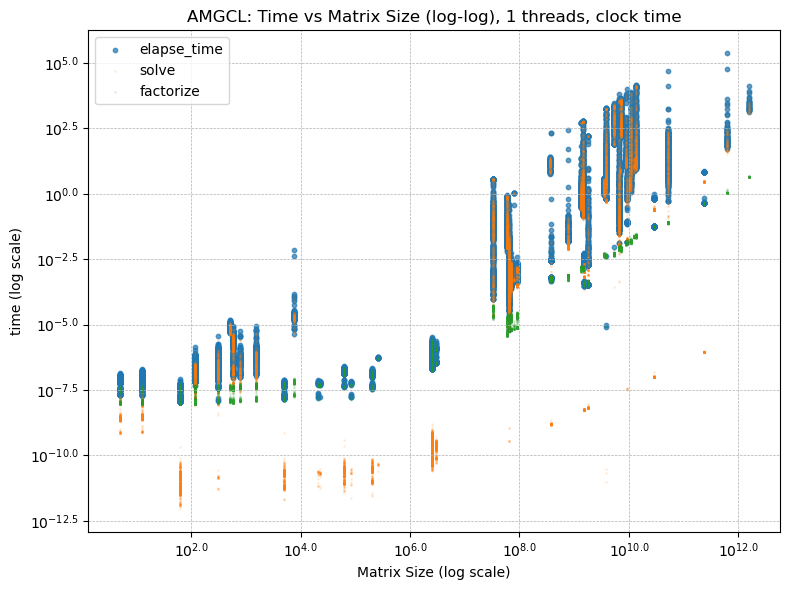

In [9]:
# df_now = df_all[df_all["solver"] == "Trilinos"]
df_now = df_all[df_all["solver"] == "AMGCL"]


def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))
plt.scatter(np.log(df_now["mat_sz"]), np.log(df_now["elapse_time"]), alpha=0.7, s=10, label="elapse_time")
plt.scatter(np.log(df_now["mat_sz"]), np.log(df_now["solve"]), alpha=0.1, s=1, label="solve")
plt.scatter(np.log(df_now["mat_sz"]), np.log(df_now["factorize"]), alpha=0.1, s=1, label="factorize")


plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("time (log scale)")
plt.title("AMGCL: Time vs Matrix Size (log-log), 1 threads, clock time")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend() 
plt.tight_layout()
plt.show()


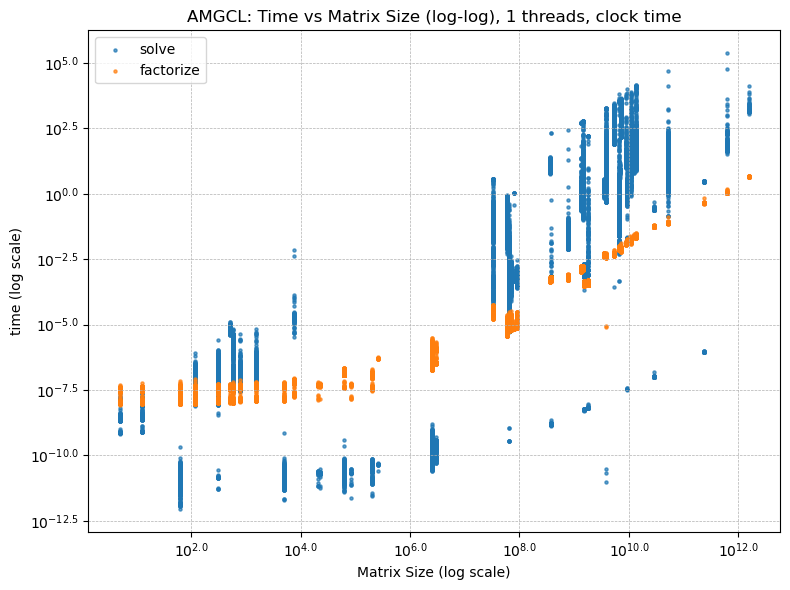

In [10]:
# df_now = df_all[df_all["solver"] == "Trilinos"]
df_now = df_all[df_all["solver"] == "AMGCL"]


def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))
plt.scatter(np.log(df_now["mat_sz"]), np.log(df_now["solve"]), alpha=0.7, s=5, label="solve")
plt.scatter(np.log(df_now["mat_sz"]), np.log(df_now["factorize"]), alpha=0.7, s=5, label="factorize")


plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("time (log scale)")
plt.title("AMGCL: Time vs Matrix Size (log-log), 1 threads, clock time")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend() 
plt.tight_layout()
plt.show()


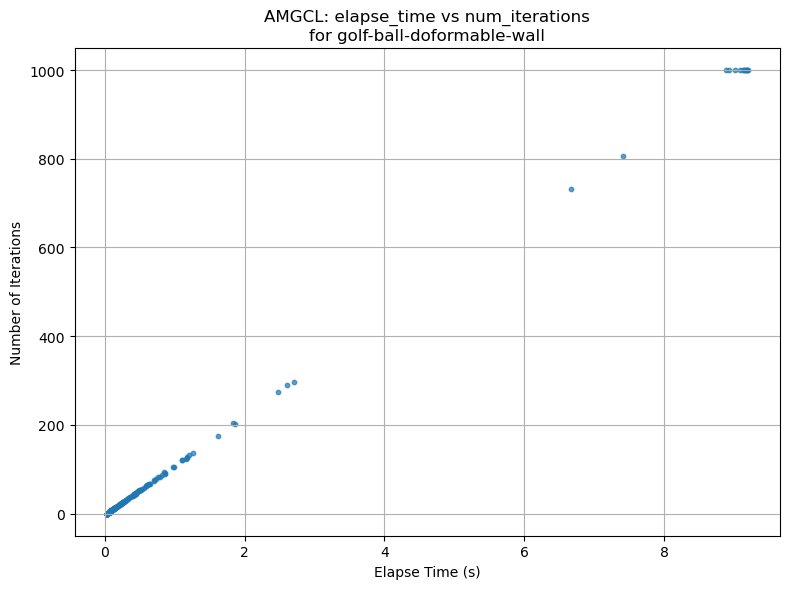

In [11]:
df_now = df_all[
    (df_all["solver"] == "AMGCL") &
    (df_all["prename"] == "golf-ball-doformable-wall")
]


plt.figure(figsize=(8, 6))
plt.scatter(df_now["elapse_time"], df_now["num_iterations"], alpha=0.7, s=10)

plt.xlabel("Elapse Time (s)")
plt.ylabel("Number of Iterations")
plt.title("AMGCL: elapse_time vs num_iterations\nfor golf-ball-doformable-wall")
plt.grid(True)
plt.tight_layout()
plt.show()

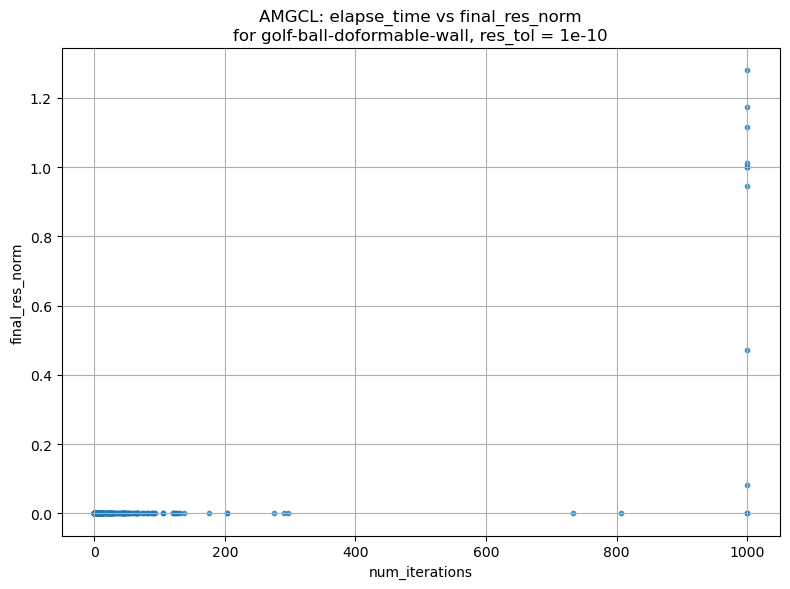

In [12]:
df_now = df_all[
    (df_all["solver"] == "AMGCL") &
    (df_all["prename"] == "golf-ball-doformable-wall")
]


plt.figure(figsize=(8, 6))
plt.scatter(df_now["num_iterations"], df_now["final_res_norm"], alpha=0.7, s=10)

plt.xlabel("num_iterations")
plt.ylabel("final_res_norm")
plt.title("AMGCL: elapse_time vs final_res_norm\nfor golf-ball-doformable-wall, res_tol = 1e-10")
plt.grid(True)
plt.tight_layout()
plt.show()

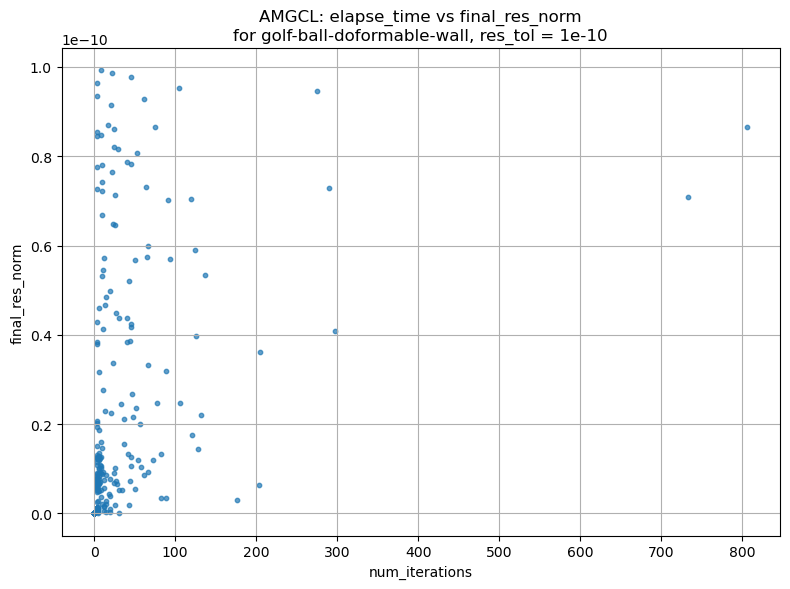

In [13]:
df_now = df_all[
    (df_all["solver"] == "AMGCL") &
    (df_all["prename"] == "golf-ball-doformable-wall") &
    (df_all["final_res_norm"] < 1e-6)
]


plt.figure(figsize=(8, 6))
plt.scatter(df_now["num_iterations"], df_now["final_res_norm"], alpha=0.7, s=10)

plt.xlabel("num_iterations")
plt.ylabel("final_res_norm")
plt.title("AMGCL: elapse_time vs final_res_norm\nfor golf-ball-doformable-wall, res_tol = 1e-10")
plt.grid(True)
plt.tight_layout()
plt.show()

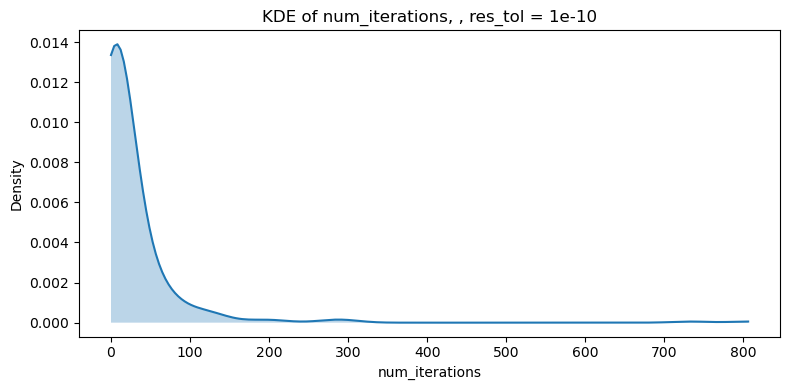

In [14]:
# Kernel density estimate (KDE) without seaborn
from scipy.stats import gaussian_kde

df_now = df_all[
    (df_all["solver"] == "AMGCL") &
    (df_all["prename"] == "golf-ball-doformable-wall") &
    (df_all["final_res_norm"] < 1e-6)
]

data = df_now["num_iterations"].values
density = gaussian_kde(data)
xs = np.linspace(data.min(), data.max(), 200)

plt.figure(figsize=(8, 4))
plt.plot(xs, density(xs))
plt.fill_between(xs, density(xs), alpha=0.3)
plt.xlabel("num_iterations")
plt.ylabel("Density")
plt.title("KDE of num_iterations, , res_tol = 1e-10")
plt.tight_layout()
plt.show()


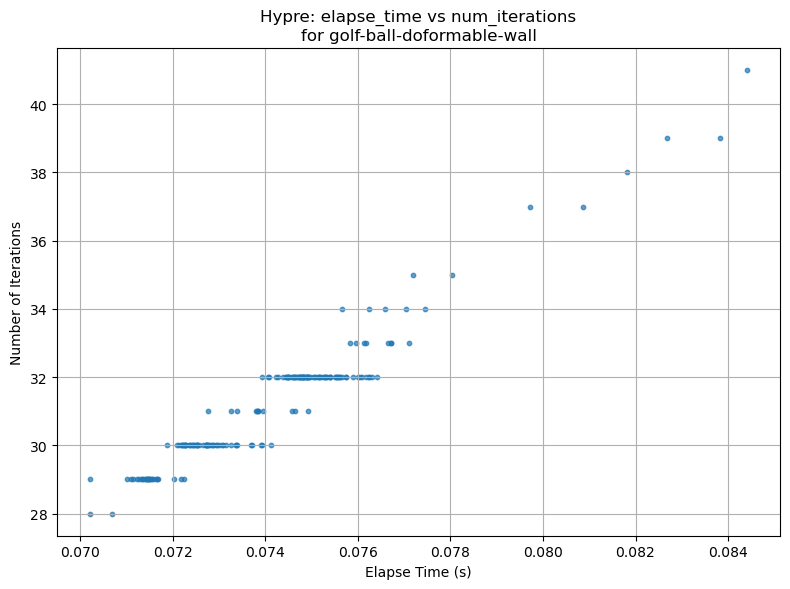

In [15]:
df_now = df_all[
    (df_all["solver"] == "Hypre") &
    (df_all["prename"] == "golf-ball-doformable-wall")
]


plt.figure(figsize=(8, 6))
plt.scatter(df_now["elapse_time"], df_now["num_iterations"], alpha=0.7, s=10)

plt.xlabel("Elapse Time (s)")
plt.ylabel("Number of Iterations")
plt.title("Hypre: elapse_time vs num_iterations\nfor golf-ball-doformable-wall")
plt.grid(True)
plt.tight_layout()
plt.show()

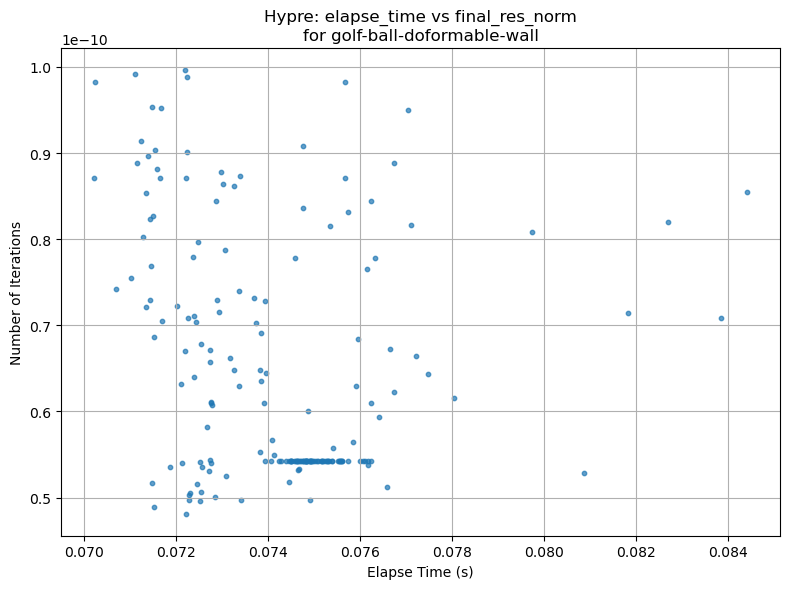

In [16]:
df_now = df_all[
    (df_all["solver"] == "Hypre") &
    (df_all["prename"] == "golf-ball-doformable-wall")
]


plt.figure(figsize=(8, 6))
plt.scatter(df_now["elapse_time"], df_now["final_res_norm"], alpha=0.7, s=10)

plt.xlabel("Elapse Time (s)")
plt.ylabel("Number of Iterations")
plt.title("Hypre: elapse_time vs final_res_norm\nfor golf-ball-doformable-wall")
plt.grid(True)
plt.tight_layout()
plt.show()

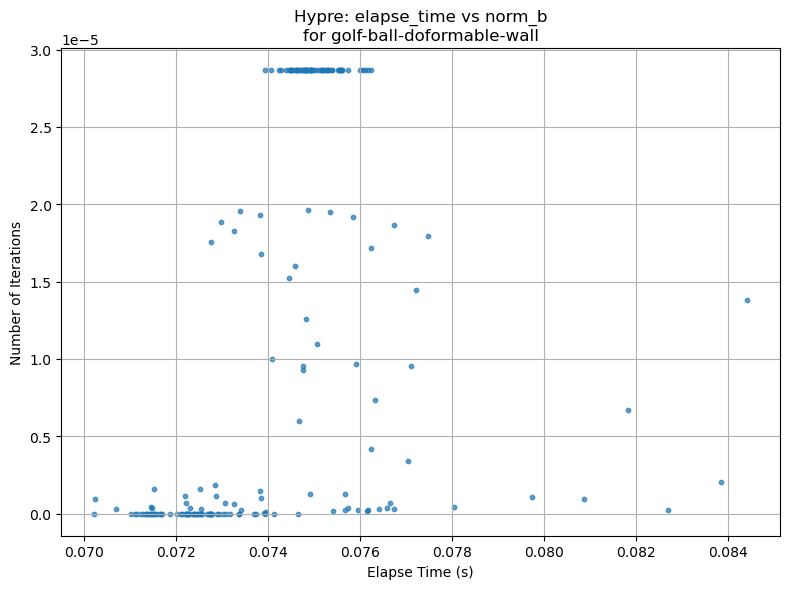

In [17]:
df_now = df_all[
    (df_all["solver"] == "Hypre") &
    (df_all["prename"] == "golf-ball-doformable-wall")
]


plt.figure(figsize=(8, 6))
plt.scatter(df_now["elapse_time"], df_now["norm_b"], alpha=0.7, s=10)

plt.xlabel("Elapse Time (s)")
plt.ylabel("Number of Iterations")
plt.title("Hypre: elapse_time vs norm_b\nfor golf-ball-doformable-wall")
plt.grid(True)
plt.tight_layout()
plt.show()